# Polynomial interpolation
This notebook demonstrates how to use PySensors to select sensor locations for polynomial interpolation using the monomial basis $1, x, x^2, x^3, \dots, x^k$. In doing so it reproduces Figure S6 from [Manhoar et al. 2018](10.1109/MCS.2018.2810460).

Reference:
* Manohar, Krithika, Bingni W. Brunton, J. Nathan Kutz, and Steven L. Brunton. "Data-driven sparse sensor placement for reconstruction: Demonstrating the benefits of exploiting known patterns." *IEEE Control Systems Magazine 38*, no. 3 (2018): 63-86.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq

from pysensors.reconstruction import SSPOR

First we construct a matrix consisting of our chosen basis modes. In this case we form a Vandermonde matrix.

In [2]:
r = 11  # Number of basis modes
n = 1000  # Number of data points in training set
x = np.linspace(0, 1, n + 1)

# Construct Vandermonde matrix (column k is x^{k-1})
vde = np.vander(x, r, increasing=True)

# PySensor objects expect rows to correspond to examples, columns to positions
X = vde.T

Next we feed this basis into a `SSPOR` object (Sparse Sensor Placement Optimization for Reconstruction), fit it to the basis, and ask it to select 10 sensor locations.

In [3]:
model = SSPOR(n_sensors=10)
model.fit(X)
sensors = model.get_selected_sensors()
print(x[sensors])

[1.    0.641 0.    0.884 0.289 0.47  0.099 0.958 0.763 0.036]


Let's define a (non-polynomial) function, sample it at a few points, and attempt to fit it with the monomial (Vandermonde) basis. We'll show that using measurements taken at the points suggested by the `SSPOR` object will lead to a much better reconstruction than equi-spaced measurements.

In [4]:
# Function to be fit
f = np.abs(x**2 - 0.5)

In [5]:
# Interpolation using the points selected by the SSPOR
pysense_interp = model.predict(f[sensors])

In [6]:
# Interpolation using equi-spaced points
equi_sensors = np.arange(0, 1001, 100)
equi_interp = np.dot(vde, lstsq(vde[equi_sensors, :], f[equi_sensors])[0])

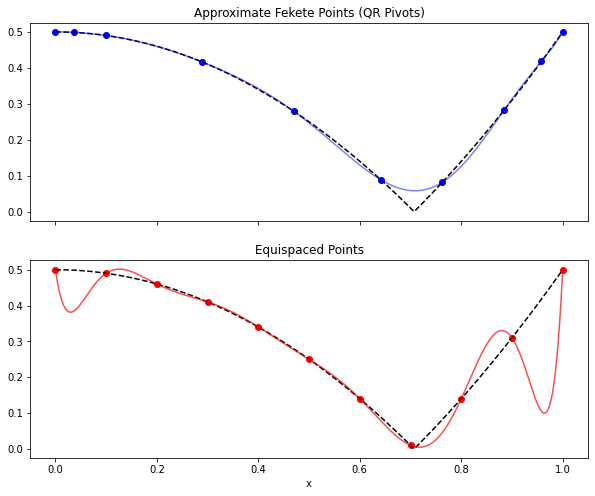

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(x[sensors], f[sensors], 'bo')
axs[0].plot(x, f, 'k--')
axs[0].plot(x, pysense_interp, 'b-', alpha=0.5)
axs[0].set(title='Approximate Fekete Points (QR Pivots)')

axs[1].plot(x[equi_sensors], f[equi_sensors], 'ro')
axs[1].plot(x, f, 'k--')
axs[1].plot(x, equi_interp, 'r-', alpha=0.7)
axs[1].set(title='Equispaced Points', xlabel='x');

Note that you can update the number of sensors at any time with the `set_number_of_sensors` function.

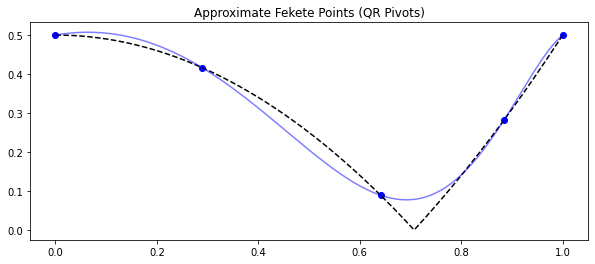

In [8]:
model.set_number_of_sensors(5)
sensors = model.get_selected_sensors()

pysense_interp = model.predict(f[sensors])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x[sensors], f[sensors], 'bo')
ax.plot(x, f, 'k--')
ax.plot(x, pysense_interp, 'b-', alpha=0.5)
ax.set(title='Approximate Fekete Points (QR Pivots)');

To see what the reconstruction error looks like as a function of the number of sensors we select, we can use the `compute_reconstruction_error` function.

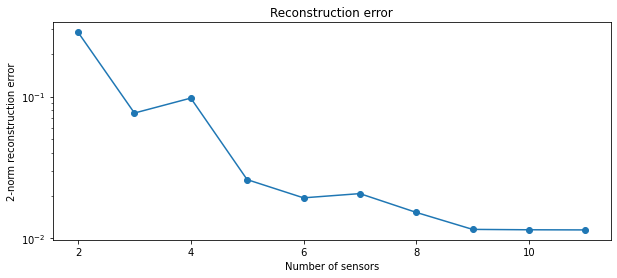

In [9]:
sensor_range = np.arange(2, r + 1)
recon_error = model.reconstruction_error(f, sensor_range)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(sensor_range, recon_error, 'o-')
ax.set(
    title='Reconstruction error',
    xlabel='Number of sensors',
    ylabel='2-norm reconstruction error',
    yscale='log'
);